## Скачиваем данные

In [1]:
! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-02-06 13:05:57--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-02-06 13:05:57 (31.6 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
!pip install jaxtyping # для kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.2 MB/s eta 0:00:00


In [3]:
import sys
import einops
import torch
import torch as t
from torch import Tensor
import torch.nn as nn
import numpy as np
import math
from tqdm.notebook import tqdm
from typing import Tuple, List, Optional, Dict, Callable
from jaxtyping import Float, Int
from transformers import AutoTokenizer

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Подготовка данных

У нас есть тексты пьесы Шекспира

In [5]:
with open("input.txt") as fin:
    text = fin.read()

print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


Создаем токенайзер, обратите внимание, что у токена there должен быть вначале спецсимвол, обозначающий, что это новое слово, а не часть предыдущего! Используем модель `openai-community/gpt2`

In [6]:
BASE_MODEL = "openai-community/gpt2"

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL) # Допишите меня! -> дописал
assert tokenizer.tokenize("Hello there sometrashtoken") == ['Hello', 'Ġthere', 'Ġsomet', 'r', 'ash', 'token']
assert tokenizer.eos_token == "<|endoftext|>"

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

В токенайзере нет спецтокена под паддинг, поэтому выставим PAD_TOKEN = EOS_TOKEN

In [7]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# Датасет - 5 баллов

Нам нужен Dataset - что-то, что будет держать данные.
Почитать подробнее можно в [документации](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) или на [примерах](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


Если кратко:
* Dataset должен реализовывать 2 метода: `__getitem__` для получения сэмплов и `__len__` для получения длины датасета
* Нужна функция collate_fn - она будет собирать несколько сэмплов из датасета в один батч
* Нужен DataLoader - объект, который будет брать объекты из датасета и с помощью collate_fn возвращать батчи
* Нужен Sampler - объект, который помогает DataLoader выбирать батчи. В нашем случае это будет просто рандом, но можно собирать сэмплы по одинаковой длине или упорядочить в зависимости от задачи.


Начнем с Dataset. В нем нужно дописать 3 функции, самая важная конструктор `__init__`:
1. Принимает текст
2. Токенизирует его
3. Бьет на непересекающиеся сэмплы размером 200-300 токенов (длину определяем с помощью random.randint)
3. Кладет токены (векторизированные!) в self.texts

In [8]:
from typing import List
import random
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):

    def __init__(self, tokenizer: AutoTokenizer, text: str):
        self.tokenizer = tokenizer
        self.texts: List[List[int]] = []
        random.seed(1)
        
        tokens = self.tokenizer.encode(text)

        index = 0
        while index < len(tokens):
            offset = random.randint(200, 300)
            if index + offset >= len(tokens):
                offset = len(tokens) - index # последний сэмпл сожержит оставшиеся токены
            self.texts.append(tokens[index:index + offset])
            index += offset


    def __getitem__(self, index) -> List[int]:
        return self.texts[index]


    def __len__(self) -> int:
        return len(self.texts)


dataset = MyDataset(tokenizer, text)

Token indices sequence length is longer than the specified maximum sequence length for this model (338025 > 1024). Running this sequence through the model will result in indexing errors


In [9]:
sample_0 = dataset.tokenizer.decode(dataset[0])

assert sample_0.startswith(text[:100])

print(sample_0)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that



# Collate FN - 5 баллов
Функция сборки, она же collate_fn. Она принимает батч сэмплов, т.е. список объектов, которые нам возвращает датасет!
Она должна принимать `List[List[int]]` батч объектов и возвращать 2 тензора:

* input_ids - `[batch, seq_len]` - батч токенов, в котором добавлены паддинги до максимальной длины в батче.
* mask - `[batch, seq_len]` - батч масок. На позиции `[i, j]` стоит 0, если токен является паддингом, иначе 1.

В качестве значения паддинга для input_ids используйте `tokenizer.pad_token_id`

In [10]:
def collate_fn(batch: List[List[int]]) -> Tuple[torch.LongTensor, torch.LongTensor]:
    batch_len = max(len(x) for x in batch)
    input_ids = t.LongTensor([x + [tokenizer.pad_token_id] * (batch_len - len(x)) for x in batch])
    mask = t.LongTensor([[1] * len(x) + [0] * (batch_len - len(x)) for x in batch])
    return input_ids, mask


batch = [
    [1, 2, 3, 4],
    [1, 2],
    [1, 2, 3, 4, 5, 6, 7],
]
input_ids_ref = torch.LongTensor([
    [1, 2, 3, 4, 50256, 50256, 50256],
    [1, 2, 50256, 50256, 50256, 50256, 50256],
    [1, 2, 3, 4, 5, 6, 7],
])


mask_ref = torch.LongTensor([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
])

input_ids, mask = collate_fn(batch)

assert (input_ids == input_ids_ref).all()
assert (mask == mask_ref).all()

# Соберем DataLoader - 5 баллов

Нужно заполнить пропущенные поля и убедиться, что в датасете есть замаскированные токены!

In [11]:
from torch.utils.data.sampler import RandomSampler

BATCH_SIZE = 16
sampler = RandomSampler(dataset)
train_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    sampler=sampler,
    collate_fn=collate_fn,
)

for input_ids, mask in train_loader:
    break
print(mask)

assert (mask.sum(dim=1) < mask.size(1)).sum() < mask.size(0)

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


# Transformer

Немного модфицированный блок трансформера, который мы скопируем с предыдущего занятия!

In [12]:
import torch
import torch.nn as nn
from dataclasses import dataclass


@dataclass
class Config:
    d_model: int = 768 # он же hidden_dim - внутрення размерность модели
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257 # он же vocab_size, размер словаря модели
    init_range: float = 0.02
    n_ctx: int = 1024 # число позиционных эмбеддингов
    d_head: int = 64 # размерность головы аттеншена
    d_mlp: int = 3072 # внутренняя размерность FFN-слоя
    n_heads: int = 12 # число голов аттеншена
    n_layers: int = 12 # число слоев трансформера

cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)


Эти модули остаются без изменений!
Скопируйте их из предыдущего домашнего задания.

In [13]:
class Embed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(t.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(self, input_ids: Int[Tensor, "batch seq_len"]) -> Float[Tensor, "batch seq_len d_model"]:
        pass
        return nn.functional.embedding(input_ids, self.W_E)

class PosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(t.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(self, input_ids: Int[Tensor, "batch seq_len"]) -> Float[Tensor, "batch seq_len d_model"]:
        batch_size, seq_len = input_ids.shape
        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)  # (batch_size, seq_len)
        return nn.functional.embedding(positions, self.W_pos)  # (batch_size, seq_len, d_model)


class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(t.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(t.zeros((cfg.d_vocab), requires_grad=False))

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"]
    ) -> Float[Tensor, "batch seq_len d_vocab"]:
        return nn.functional.linear(x, t.transpose(self.W_U, 0, 1), self.b_U)

class MLP(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(t.empty((cfg.d_model, cfg.d_mlp)))
        self.W_out = nn.Parameter(t.empty((cfg.d_mlp, cfg.d_model)))
        self.b_in = nn.Parameter(t.zeros((cfg.d_mlp)))
        self.b_out = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        nn.init.normal_(self.W_out, std=self.cfg.init_range)

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"]
    ) -> Float[Tensor, "batch seq_len d_model"]:
        output_1 = nn.functional.gelu(t.matmul(x, self.W_in) + self.b_in, approximate="tanh")
        output = t.matmul(output_1, self.W_out) + self.b_out
        return output

# RMSNorm - 5 баллов
https://arxiv.org/pdf/1910.07467

In [14]:
class RMSNorm(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(t.ones(cfg.d_model)) # gamma

    def forward(self, x: Float[Tensor, "batch seq_len d_model"]) -> Float[Tensor, "batch seq_len d_model"]:
        rms = t.sqrt(t.mean(t.square(x), dim=-1, keepdim=True) + self.cfg.layer_norm_eps)
        output = x / rms # не центрируется, а только масштабируется
        return self.w * output


cfg_rmsnorm = Config(d_model=5)
x = torch.Tensor([[[0.1, 0.2, 0.3, 0.4, 0.5]]])
layer = RMSNorm(cfg_rmsnorm)
y = torch.Tensor([[[0.3015, 0.6030, 0.9045, 1.2060, 1.5076]]])
assert torch.allclose(y, layer(x), atol=1e-4, rtol=1e-3)

# Attention

## Attention Masking - 10 баллов

Опять же копируем имлементацию из предыдущего кода.
Но теперь нужно учесть и маски с паддингами.
Для этого в `apply_causal_mask` подана mask.

В оригинальном задании 3 мы считали, что паддингов нет, поэтому делали маску нижней треугольной, чтобы токен i смотрел на токен j только тогда, когда `i >= j`, т.е. токен i мог смотреть все токены до него.

Теперь же нужно сверх этого добавить еще и паддинг, т.е:

1. Нам дается маска `[batch_size, seq_len]` из `collate_fn`. Напомню, что на позиции `[batch_idx, m]` стоит 1, если токен настоящий или 0, если это паддинг
2. Мы должны модифицировать нашу нижнюю треугольную маску таким образом, чтобы не только не смотреть в будущее, но и не смотреть на паддинг.

In [15]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))

        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))

        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))

        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))

        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"], mask: Int[Tensor, "batch seq_len"]
    ) -> Float[Tensor, "batch seq_len d_model"]:
        # Берем размерности
        batch_size, seq_len, d_model = x.shape
        num_heads = self.cfg.n_heads
        d_head = self.cfg.d_head
        
        # 1. Трансформируем матрицы проекций в формат [d_model, d_model]
        W_Q = self.W_Q.permute(1, 0, 2).reshape(self.cfg.d_model, self.cfg.d_model)
        W_K = self.W_K.permute(1, 0, 2).reshape(self.cfg.d_model, self.cfg.d_model)
        W_V = self.W_V.permute(1, 0, 2).reshape(self.cfg.d_model, self.cfg.d_model)
        W_O = self.W_O.reshape(self.cfg.d_model, self.cfg.d_model)
        
        b_Q = self.b_Q.view(-1)
        b_K = self.b_K.view(-1)
        b_V = self.b_V.view(-1)
        
        # 1. получаем проекции  Q, K, V
        Q = t.matmul(x, W_Q) + b_Q
        K = t.matmul(x, W_K) + b_K
        V = t.matmul(x, W_V) + b_V
        
        # 1.5. Привести к размерностям [batch_size, seq_len, num_heads, d_head]
        Q = Q.view(batch_size, seq_len, num_heads, d_head)
        K = K.view(batch_size, seq_len, num_heads, d_head)
        V = V.view(batch_size, seq_len, num_heads, d_head)
        
        # 2. Q x K^T
        # Привести к [batch_size, num_heads, seq_len, d_head]
        Q = Q.permute(0, 2, 1, 3)  # [batch_size, num_heads, seq_len, d_head]
        K = K.permute(0, 2, 1, 3)  # [batch_size, num_heads, seq_len, d_head]
        V = V.permute(0, 2, 1, 3)  # [batch_size, num_heads, seq_len, d_head]

        attn_scores = t.matmul(Q, K.transpose(-1, -2)) # [batch_size, num_heads, seq_len, seq_len]
        
        # 3. Нормализация
        attn_scores = attn_scores / t.sqrt(t.tensor(d_head, dtype=t.float32, device=x.device))
        
        # 4. Маскирование
        attn_scores = self.apply_causal_mask(attn_scores, mask) # добавил аргумент mask
        
        # 5. softmax
        attn_probs = nn.functional.softmax(attn_scores, dim=-1) # [batch_size, num_heads, seq_len, seq_len]

        # 6. Финальная проекция
        attn_output = t.matmul(attn_probs, V) # [batch_size, num_heads, seq_len, d_head]

        # 7. Собрать матрицу [batch_size, seq_len, d_model]
        attn_output = attn_output.permute(0, 2, 1, 3)
        attn_output = attn_output.contiguous().view(batch_size, seq_len, -1)

        # 8. Умножить на W_O
        output = t.matmul(attn_output, W_O) + self.b_O

        return output

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads seq_len seq_len"], mask: Int[Tensor, "batch seq_len"]
    ) -> Float[Tensor, "batch n_heads seq_len seq_len"]:
        '''
        Applies a causal mask to attention scores, and returns masked scores.
        Используем треугольную маску, чтобы не смотреть в будущее!
        В качестве масикировочного значения перед софтмаксом можно использовать self.IGNORE (-inf)
        '''
        seq_len = attn_scores.shape[-1]
        tri_mask = t.triu(t.ones((seq_len, seq_len), device=attn_scores.device), diagonal=1).to(attn_scores.device)
        ignore_val = self.IGNORE.to(attn_scores.device)
        attn_scores = attn_scores.masked_fill(tri_mask == 1, ignore_val) # сначала применяю треугольную маску

        pad_mask = mask.unsqueeze(1).unsqueeze(2)  # [batch, 1, 1, seq_len]
        pad_mask = pad_mask.expand(-1, attn_scores.shape[1], seq_len, -1) # [batch, n_heads, seq_len, seq_len]
        pad_mask = pad_mask.to(attn_scores.device)
        attn_scores = attn_scores.masked_fill(pad_mask == 0, ignore_val) # потом маску с паддингами
        return attn_scores


mask_padding = torch.LongTensor([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
])

lengths = mask_padding.sum(dim=1).tolist()


batch_size = 3
seq_len = 7
d_head = 8
n_heads = 4

x = torch.rand(batch_size, n_heads, seq_len, seq_len).to(device)

attn = Attention(cfg)
softmax_res = torch.softmax(attn.apply_causal_mask(x, mask_padding), dim=-1)

for batch_idx in range(batch_size):
    for head_idx in range(n_heads):
        sm = softmax_res[batch_idx, head_idx]
        l = lengths[batch_idx]
        for i in range(seq_len):
            for j in range(seq_len):
                # i < j - Causal mask, проверяем, что не смотрим в будущее!
                # j >= l - проверяем, что не смотрим на паддинги!
                if i < j or j >= l:
                    assert sm[i, j] == 0, (batch_idx, head_idx, i, j, sm[i, j])

_ = attn(torch.rand(batch_size, seq_len, 768), mask_padding)

## Rotary Embeddings - 5 баллов

Нужно написать роторные эмбеддинги из [статьи](https://arxiv.org/pdf/2104.09864). В качестве формулы нужно взять пункт 3.4.2!

Их можно использовать в attention, но это не обязательно, здесь баллы даются только за имплементацию самих роторных эмбеддингов.


Что нужно сделать в `__init__` (все нужно делать опираясь на формулу 34 из статьи):
1. Сделать 2 матрицы $cos(m\theta_i)$, $sin(m\theta_i$. Это будут матрицы размера `[max_seq_len, d_head]`
2. Берем от матрицы синусы, косинусы.
3. Дальше мы их добавляем в модель через register_buffer. Для удобства сразу делаем фиктивные доп размерности для batch_size, num_heads.


Что нужно сделать в `rotate_neg_vector`:

1. По формуле 34 вернуть по вектору `[x1, x2, x3, x4, ... x_{n-1}, x_n]` новый вектор `[-x2, x1, -x4, x3, ..., -x_n, x_{n-1}]`


Что нужно сделать в `forward`:
1. Получить вектор x' `[-x2, x1, -x4, x3, ..., -x_n, x_{n-1}]`
2. Применить для x и x' формулу 34

In [16]:
class RotaryPositionalEmbeddings(nn.Module):

    def __init__(self, cfg: Config, theta: int = 10_000):
        super().__init__()
        self.cfg = cfg
        self.max_seq_len = cfg.n_ctx
        self.theta = theta
        self.d = cfg.d_head

        # Углы theta_i. Смотрите секуцию 3.2 статьи для формулы!
        indices = torch.arange(0, self.d // 2, dtype=torch.float32)
        freqs = self.theta ** (-2.0 * indices / self.d) # тут список из тэт в разных степенях

        position_id = torch.arange(0, self.max_seq_len, dtype=torch.float32).unsqueeze(1)

        # нужно получить матрицу m theta_i размера [max_seq_len, self.d/2] вида m theta_i
        # где m берется из position_id, а theta из freqs
        idx_theta = position_id * freqs.unsqueeze(0)  # [max_seq_len, d/2], тэты умножаются на номера позиций

        # нужно продублировать размерности для формулы 34. theta_i встерчается два раза подряд в синусах и косинуса
        # тут нам поможет torch.repeat_interleave
        idx_theta = torch.repeat_interleave(idx_theta, repeats=2, dim=-1) # элементы дублируются
        
        cos = idx_theta.cos()
        sin = idx_theta.sin()

        # 1, max_seq_len, 1, d_head
        self.register_buffer("sin", sin.view(1, self.max_seq_len, 1, self.d))
        self.register_buffer("cos", cos.view(1, self.max_seq_len, 1, self.d))

    @staticmethod
    def rotate_neg_vector(x: Float[torch.Tensor, "batch seq_len num_heads d_head"]):
        # На входе x = [x1, x2, x3, x4, ... x_{n-1}, x_n]
        # На выходе x' = [-x2, x1, -x4, x3, ..., -x_n, x_{n-1}]
        x_new = torch.empty_like(x)
        x_new[..., 0::2] = -x[..., 1::2]  # -x2, -x4, ..., -x_n
        x_new[..., 1::2] = x[..., 0::2]   # x1, x3, ..., x_{n-1}
        return x_new

    def forward(self, x: Float[torch.Tensor, "batch seq_len num_heads d_head"]):
        seq_len = x.size(1)
        sin, cos = self.sin[:, :seq_len, :, :], self.cos[:, :seq_len, :, :]
        x_rotated = self.rotate_neg_vector(x)
        x_out = x * cos + x_rotated * sin
        return x_out

In [17]:
# в этой ячейке только тесты
batch_size = 1
seq_len = 3
num_heads = 2
d_head = 16

torch.manual_seed(1)
x = torch.rand(batch_size, seq_len, num_heads, d_head)

rope_config = Config(
    n_heads=2,
    d_head=16,
)

rope_layer = RotaryPositionalEmbeddings(rope_config)
y = rope_layer(x)


from math import sin, cos


thetas = [10_000 ** (-2 * (i - 1) / rope_config.d_head) for i in range(1, rope_config.d_head // 2 + 1)]
all_good = True
for batch_idx in range(batch_size):
    for m in range(seq_len):
        if not all_good:
            break
        for head_idx in range(num_heads):
            if not all_good:
                break
            for d_idx in range(d_head):
                # 0, 2, 4
                if d_idx % 2 == 0:
                    val = x[batch_idx, m, head_idx, d_idx] * cos(m * thetas[d_idx // 2]) - x[batch_idx, m, head_idx, d_idx + 1] * sin(m * thetas[d_idx // 2])
                else:
                    val = x[batch_idx, m, head_idx, d_idx] * cos(m * thetas[d_idx // 2]) + x[batch_idx, m, head_idx, d_idx - 1] * sin(m * thetas[d_idx // 2])
                if abs(y[batch_idx, m, head_idx, d_idx] - val) > 1e-3:
                    print(f"Ошибка на позиции {m} и размерности {d_idx} в голове {head_idx}")
                    print(f"Полученное значение {y[batch_idx, m, head_idx, d_idx]}, референс {val}")
                    all_good = False
                    break


if all_good:
    print("Тесты прошли успешно!")

Тесты прошли успешно!


# Rope X Attention

Если хотите обучаться с RoPE вместо позиционных эмбеддингов, то ниже можете написать новый класс Attention, где будете "вращать" Q, K. Не забудьте только дальше в DemoTransformer убрать позиционные эмбеддинги

**В независимости от вашего решения напишите ответ на вопрос.**

В модели есть RoPE-слой. theta = 10.000, максимальное число позиций 1024. Размерность головы (размерность RoPE для простоты 16). Какое число обучаемых параметров в RoPE-слое?

Ваш ответ:




In [18]:
# 0, ноль, нуль

# Собираем Transformer - 5 баллов

1. В TransformerBlock и DemoTransformer немного модифицируем код из предыдущего задания, чтобы передавать mask в слои аттеншена.
2. В зависимости от того, хотим ли мы использовать RoPE или не хотим меняется также то, используем ли мы Positional Embeddings или нет!

В задании не будут сниматься баллы, если используются абсолютные позиционные эмбеддинги.


In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = RMSNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = RMSNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"], mask: Float[Tensor, "batch seq_len"]
    ) -> Float[Tensor, "batch seq_len d_model"]:
        x_norm_1 = self.ln1(x)
        x_attn = self.attn(x_norm_1, mask) # добавил аргумент mask
        x_norm_2 = self.ln2(x_attn + x)
        x_mlp = self.mlp(x_norm_2)
        return (x_attn + x) + x_mlp

class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = RMSNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(self, input_ids: Int[Tensor, "batch seq_len"], mask: Int[Tensor, "batch seq_len"]) -> Float[Tensor, "batch seq_len d_vocab"]:
        x = self.embed(input_ids) + self.pos_embed(input_ids)
        for block in self.blocks:
            x = block(x, mask) # добавил аргумент mask
        x = self.ln_final(x)
        x = self.unembed(x)
        return x

# Финальные проверки

In [20]:
train_config = Config(
    d_model=128,
    n_ctx=512,
    n_heads=8,
    d_head=16,
    d_mlp=512,
    n_layers=12
)
model = DemoTransformer(train_config)

In [21]:
for input_ids, mask in train_loader:
    break

with torch.no_grad():
    p = model(input_ids, mask)

assert list(p.shape) == [input_ids.size(0), input_ids.size(1), train_config.d_vocab]

# Обучение - 5 баллов

Здесь нужно написать обычный training loop! Но он не так уж и прост. Давайте по шагам разберемся, как нам быть:
1. Берем input_ids, mask, прогоняем через модель, получаем тензор logits `[batch_size, seq_len, vocab_size]`
2. В качестве меток мы берем input_ids! Только нужно их обрезать по размерности seq_len таким образом, чтобы i-й токен предсказывал (i + 1)-й!

3. В качестве предиктов берем logits! Его тоже нужно правильно обрезать, т.к. по последнему токену нам нечего предсказывать.

4. Паддингам ставим метки -100, это значение ignore_loss, [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) его игнорирует при подсчете лососв!
5. Превращаем p в тензор `[batch_size * (seq_len - 1), vocab_size]`, вектор правильных меток labels (из input_ids) превращаем в `[batch_size * (seq_len - 1)]`, считаем функцию потерь!
6. Не забываем все стандартные вещи в training loop: обнуление градиентов, backward, шаг оптимизации.


Вначале напишем функцию потерь!

In [22]:
from math import log


criterion = nn.CrossEntropyLoss()
pad_id = 50256

def calculate_loss(criterion, logits, input_ids, pad_id=pad_id):
    labels = input_ids[:, 1:].clone()
    input_ids = input_ids[:, :-1]
    logits = logits[:, :-1, :]
    
    labels[labels == pad_id] = -100
    
    logits = logits.reshape(-1, logits.size(-1))  # [batch_size * (seq_len - 1), vocab_size]
    labels = labels.reshape(-1)  # [batch_size * (seq_len - 1)]
    return criterion(logits, labels)


batch_size = 2
seq_len = 4
num_classes = 7

input_ids = torch.LongTensor(
    [
        [0, 1,  pad_id, pad_id],
        [0, 1, 2, 3]
    ]
)

# batch_size, seq_len, num_classes
logits = torch.Tensor(
    [[[0.7576, 0.2793, 0.4031, 0.7347, 0.0293, 0.7999, 0.3971],
         [0.7544, 0.5695, 0.4388, 0.6387, 0.5247, 0.6826, 0.3051],
         [0.4635, 0.4550, 0.5725, 0.4980, 0.9371, 0.6556, 0.3138],
         [0.1980, 0.4162, 0.2843, 0.3398, 0.5239, 0.7981, 0.7718]],

        [[0.0112, 0.8100, 0.6397, 0.9743, 0.8300, 0.0444, 0.0246],
         [0.2588, 0.9391, 0.4167, 0.7140, 0.2676, 0.9906, 0.2885],
         [0.8750, 0.5059, 0.2366, 0.7570, 0.2346, 0.6471, 0.3556],
         [0.4452, 0.0193, 0.2616, 0.7713, 0.3785, 0.9980, 0.9008]]]
)

loss = calculate_loss(criterion, logits, input_ids)

assert abs(loss.item() - 1.9343) < 1e-2

А теперь с помощью `calculate_loss` напишем цикл ообучения

In [23]:
import torch.optim as optim

model = model.to(device)
model = model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

losses = []
for epoch in range(10):
    for input_ids, mask in tqdm(train_loader):
        input_ids = input_ids.to(device)
        mask = mask.to(device)
        
        logits = model(input_ids, mask)
        loss = calculate_loss(criterion, logits, input_ids)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print("Current loss:", losses[-1])

  0%|          | 0/85 [00:00<?, ?it/s]

Current loss: 5.966512680053711


  0%|          | 0/85 [00:00<?, ?it/s]

Current loss: 5.510433673858643


  0%|          | 0/85 [00:00<?, ?it/s]

Current loss: 5.153843879699707


  0%|          | 0/85 [00:00<?, ?it/s]

Current loss: 4.831369876861572


  0%|          | 0/85 [00:00<?, ?it/s]

Current loss: 4.767427921295166


  0%|          | 0/85 [00:00<?, ?it/s]

Current loss: 4.246819496154785


  0%|          | 0/85 [00:00<?, ?it/s]

Current loss: 4.13888692855835


  0%|          | 0/85 [00:00<?, ?it/s]

Current loss: 4.065956115722656


  0%|          | 0/85 [00:00<?, ?it/s]

Current loss: 3.8127710819244385


  0%|          | 0/85 [00:00<?, ?it/s]

Current loss: 3.7128872871398926


Лоссы должны идти вниз

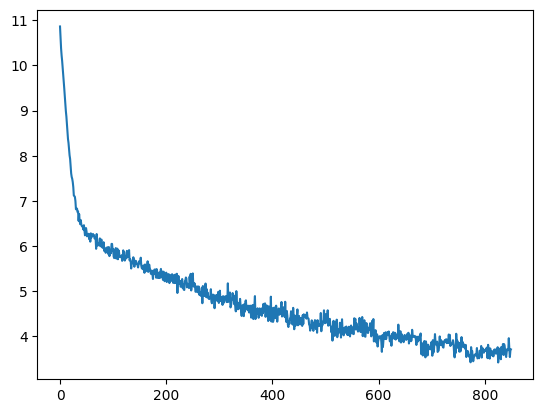

In [24]:
import matplotlib.pyplot as plt
plt.plot(losses)

# Генерация - 5 баллов
Давайте теперь попробуем посмотреть, что у нас обучилось! Для этого проверим себя на жадной генерации. KV-cache не пишем, просто:
1. Подаем input_ids, mask
2. По последнему токену жадно предсказываем следующий
3. Конактенируем этот токен к input_ids, расширяем mask
4. Повторяем num_tokens_to_generate раз

In [25]:
input_text = text[:5]
inputs = tokenizer(input_text, return_tensors="pt")

input_ids = inputs["input_ids"]
mask = inputs["attention_mask"]

orig_size = input_ids.size(1)

num_tokens_to_generate = 10

with torch.no_grad():
    for i in range(num_tokens_to_generate):
        input_ids = input_ids.to(device)
        mask = mask.to(device)
        
        logits = model(input_ids, mask)
        last_token_logits = logits[:, -1, :]
        next_token = torch.argmax(last_token_logits, dim=-1)
        input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim=1)

print("Input text:\n", input_text)
print("Input text + Generated:\n", tokenizer.decode(input_ids[0]))

Input text:
 First
Input text + Generated:
 First:
I have the king, and the king


Если все прошло успешно, то мы увидим какой-то небольшой, но скорее всего повторяющийся текст.

Осталось отмашстабировать модель, накинуть данных и наша LLM готова!